In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

# Read in original data
choices = pd.read_csv("data/choices.csv", sep=",")
subjects = pd.read_csv("data/subjects.csv", sep=",")

# Merge datasets on 'sid' column
merged_df = pd.merge(choices, subjects, on='sid', how='outer', indicator=True)
merged_df.to_csv("data/merged_df.csv", index=False)

# Merge datasets on 'sid' column and create an indicator for missing data
merged_df_includes_missing_data = pd.merge(choices, subjects, on='sid', how='outer', indicator=True)
merged_df_includes_missing_data['missing_data'] = merged_df_includes_missing_data['_merge'] != 'both'

# List the IDs of the subjects with missing data
missing_subjects = merged_df_includes_missing_data[merged_df_includes_missing_data['missing_data']]['sid'].unique()

# Save df with missing data to csv
merged_df_includes_missing_data.to_csv("data/merged_df_includes_missing_data.csv", index=False)

# Calculate the extent of missingness
missing_data_summary = merged_df_includes_missing_data.isnull().sum().reset_index()
missing_data_summary.columns = ['Variable', 'Missing_Count']
missing_data_summary['Missing_Percentage'] = (missing_data_summary['Missing_Count'] / len(merged_df_includes_missing_data)) * 100

# Sort by percentage of missing values in descending order
missing_data_summary = missing_data_summary.sort_values(by='Missing_Percentage', ascending=False)

# Display the summary
print(missing_data_summary)


             Variable  Missing_Count  Missing_Percentage
13        bf_openness            546            8.045977
14    bf_extraversion            546            8.045977
24          pe_female            546            8.045977
23             pe_age            546            8.045977
22        pe_monthinc            546            8.045977
21     pe_D1_stud_med            546            8.045977
20  pe_D1_stud_socsci            546            8.045977
19     pe_D1_stud_law            546            8.045977
18  pe_D1_stud_natsci            546            8.045977
17            cogabil            546            8.045977
16     bf_neuroticism            546            8.045977
12   bf_consciousness            546            8.045977
15   bf_agreeableness            546            8.045977
25             _merge              0            0.000000
0                 sid              0            0.000000
1                 gid              0            0.000000
11                r_x          

In [2]:
# Check for entirely missing subjects
missing_subjects_only_in_choices = merged_df_includes_missing_data[merged_df_includes_missing_data['_merge'] == 'left_only']['sid'].unique()

# Check for subjects with some columns missing
subjects_with_some_columns_missing = merged_df_includes_missing_data[(merged_df_includes_missing_data['_merge'] == 'both') & (merged_df_includes_missing_data.isnull().any(axis=1))]['sid'].unique()

# Display the results
print("SIDs of entirely missing subjects:")
print(missing_subjects_only_in_choices)

print("\nSIDs of subjects with some columns missing:")
print(subjects_with_some_columns_missing)

SIDs of entirely missing subjects:
[ 62010050706  82010050705 102010050706 122010050603 132010050706
 152010050706 162010050502 172010050501 172010050704 192010050502
 202010050704 212010050704 292010050502 362010050501]

SIDs of subjects with some columns missing:
[]


In [3]:
# This shows that there are some choices in the choices dataset that do not have a corresponding subject in the subjects' dataset.
# So for now, let's remove these rows from the merged dataset. Because simple imputing the missing values would not make sense in this case, since we don't have any information about the subjects. We will later try to find a way to create subjects for these choices.

# Remove rows with missing subjects from the merged dataset
merged_df_cleaned = merged_df_includes_missing_data[merged_df_includes_missing_data['_merge'] == 'both']
merged_df_cleaned = merged_df_cleaned.drop(columns=['_merge', 'missing_data'])
merged_df_cleaned.to_csv("data/merged_df_cleaned_missing_subjects.csv", index=False)


# Problem 3 a)

Try to predict the choices of subjects using the information provided. Report the performance measures for different predictor variables.

In [4]:
# First, we created reusable methods for training and evaluating models.

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

def preprocess_data(df, features, target):
    # Drop rows with missing data
    df = df.dropna(subset=features + [target])
    
    # Define features and target
    X = df[features]
    y = df[target]
    
    # Handle missing values by filling with the mean
    # X = X.fillna(X.mean())
    
    return X, y

def split_and_scale_data(X, y, test_size=0.2, random_state=42):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Standardize the feature variables
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

def train_and_evaluate_model(model, X_train, X_test, y_train, y_test):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True)
    
    # Calculate ROC-AUC
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_proba)
    else:
        roc_auc = None
    
    return accuracy, conf_matrix, class_report, roc_auc

def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

def plot_classification_report(class_report):
    report_df = pd.DataFrame(class_report).transpose()
    plt.figure(figsize=(10, 6))
    sns.heatmap(report_df.iloc[:-1, :-1].T, annot=True, cmap='Blues')
    plt.title('Classification Report')
    plt.show()

def plot_roc_curve(y_test, y_proba):
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

def feature_importance_rf(model, features):
    feature_importances = model.feature_importances_
    feature_importances_df = pd.DataFrame({
        'Feature': features,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)
    
    print(feature_importances_df)
    return feature_importances_df


Training Logistic Regression...
Best parameters for Logistic Regression: {'C': 1}
Accuracy: 0.8974358974358975
ROC-AUC: 0.8740776794544521


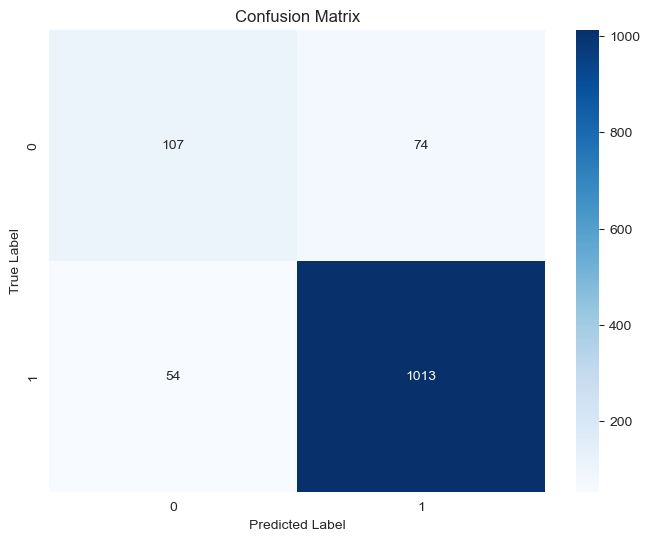

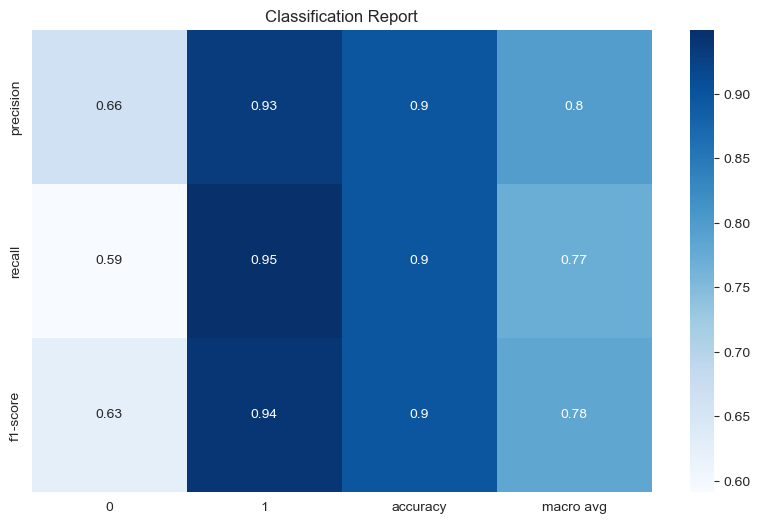

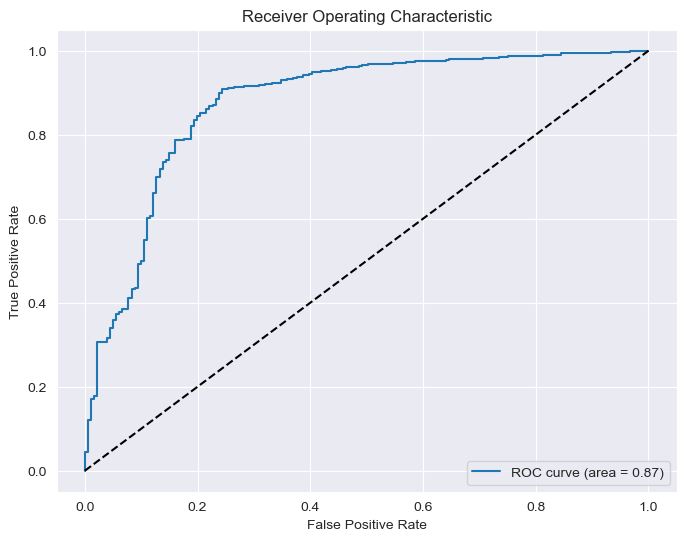

Training Random Forest...
Best parameters for Random Forest: {'max_features': 'sqrt', 'n_estimators': 100}
Accuracy: 0.8942307692307693
ROC-AUC: 0.919141290446183


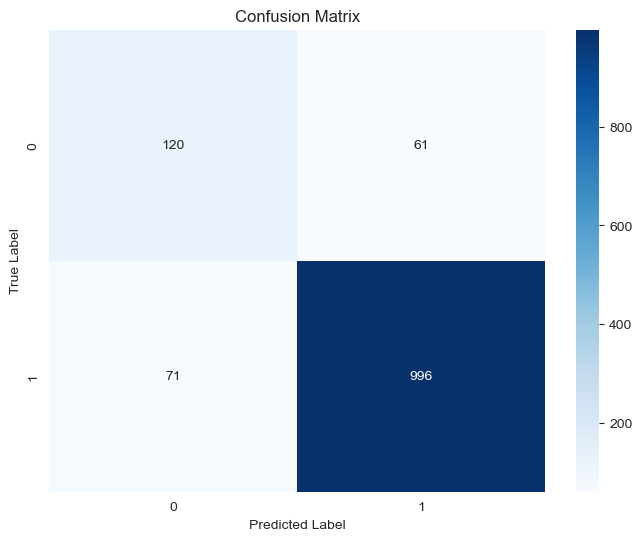

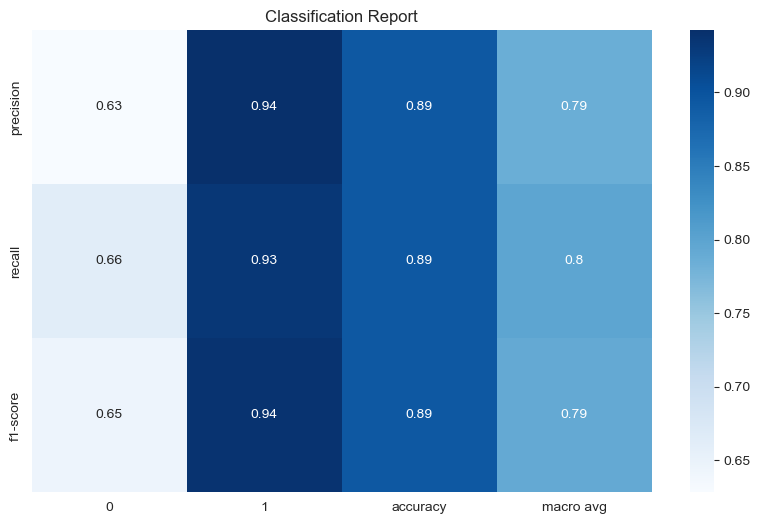

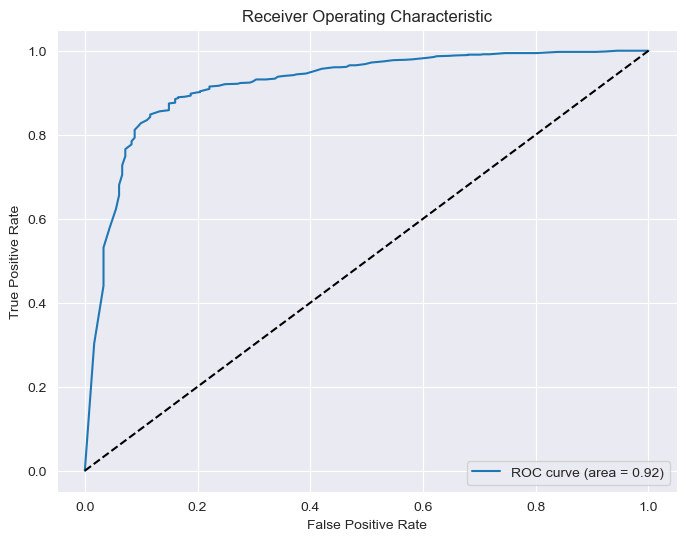

Training SVM...
Best parameters for SVM: {'C': 100, 'kernel': 'rbf'}
Accuracy: 0.9086538461538461
ROC-AUC: 0.9308382566911928


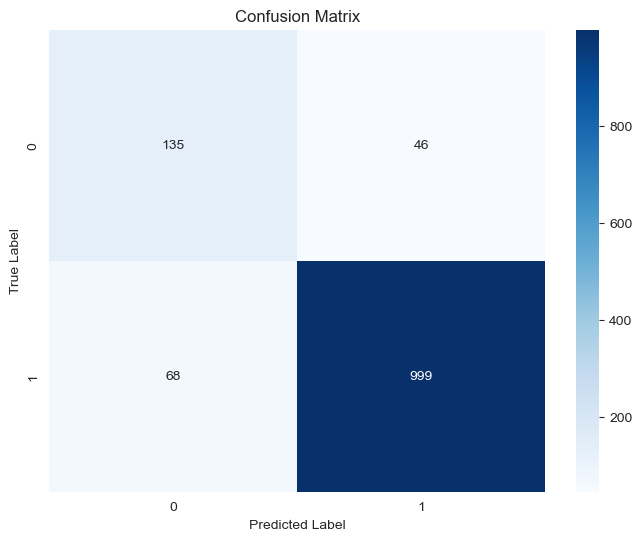

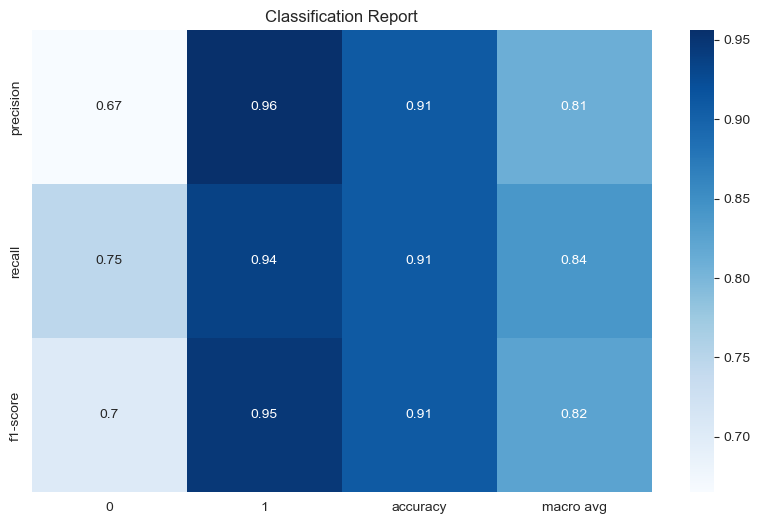

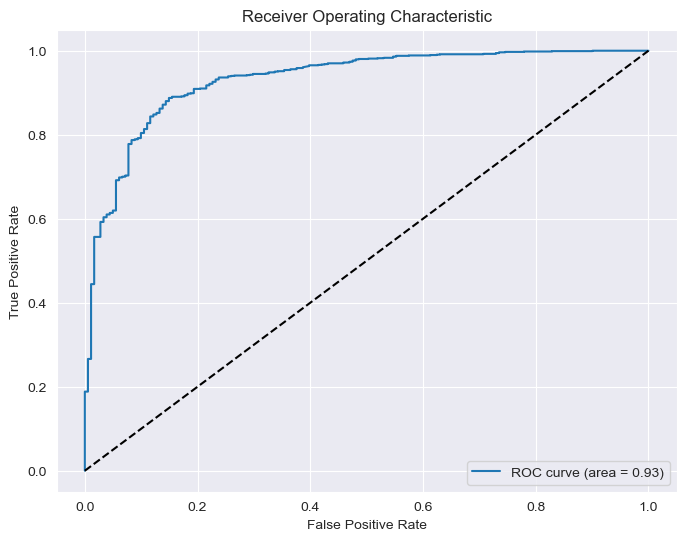

                     Accuracy   ROC-AUC
Logistic Regression  0.897436  0.874078
Random Forest        0.894231  0.919141
SVM                  0.908654  0.930838
              Feature  Importance
2             other_x    0.161293
0              self_x    0.119453
3             other_y    0.105266
1              self_y    0.097914
18        pe_monthinc    0.061631
12     bf_neuroticism    0.060321
10    bf_extraversion    0.056335
9         bf_openness    0.056151
13            cogabil    0.053470
8    bf_consciousness    0.052896
11   bf_agreeableness    0.051493
19             pe_age    0.045892
20          pe_female    0.017775
14  pe_D1_stud_natsci    0.013294
6                 r_x    0.008960
17     pe_D1_stud_med    0.007935
16  pe_D1_stud_socsci    0.007166
7                 r_y    0.007060
5                 s_y    0.005790
4                 s_x    0.005372
15     pe_D1_stud_law    0.004534


,Feature,Importance
2,other_x,0.161293
0,self_x,0.119453
3,other_y,0.105266
1,self_y,0.097914
18,pe_monthinc,0.061631
12,bf_neuroticism,0.060321
10,bf_extraversion,0.056335
9,bf_openness,0.056151
13,cogabil,0.053470
8,bf_consciousness,0.052896


In [5]:
# Now we concentrate to create the best prediction model for the choice_x variable. We will use the cleaned dataset for this purpose.
# Define feature columns and target variable
features = ['self_x', 'self_y', 'other_x', 'other_y', 's_x', 's_y', 'r_x', 'r_y',
            'bf_consciousness', 'bf_openness', 'bf_extraversion', 'bf_agreeableness', 
            'bf_neuroticism', 'cogabil', 'pe_D1_stud_natsci', 'pe_D1_stud_law', 
            'pe_D1_stud_socsci', 'pe_D1_stud_med', 'pe_monthinc', 'pe_age', 'pe_female']
target = 'choice_x'

# Preprocess the data
X, y = preprocess_data(merged_df_cleaned, features, target)

# Split and scale the data
X_train, X_test, y_train, y_test = split_and_scale_data(X, y)

# Define models and hyperparameters for tuning
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True)
}

param_grids = {
    'Logistic Regression': {'C': [0.01, 0.1, 1, 10, 100]},
    'Random Forest': {'n_estimators': [10, 50, 100], 'max_features': ['sqrt', 'log2']},
    'SVM': {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['linear', 'rbf']}
}

# Train and evaluate each model with hyperparameter tuning
results = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    grid_search = GridSearchCV(model, param_grids[model_name], cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    
    accuracy, conf_matrix, class_report, roc_auc = train_and_evaluate_model(best_model, X_train, X_test, y_train, y_test)
    
    results[model_name] = {
        'model': best_model,
        'accuracy': accuracy,
        'conf_matrix': conf_matrix,
        'class_report': class_report,
        'roc_auc': roc_auc
    }

    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Accuracy: {accuracy}")
    if roc_auc:
        print(f"ROC-AUC: {roc_auc}")
    plot_confusion_matrix(conf_matrix)
    plot_classification_report(class_report)
    if roc_auc:
        plot_roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])

# Compare the models
comparison_df = pd.DataFrame({
    model_name: {
        'Accuracy': result['accuracy'],
        'ROC-AUC': result['roc_auc']
    } for model_name, result in results.items()
}).T

print(comparison_df)

# Feature importance for RandomForest
feature_importance_rf(results['Random Forest']['model'], features)

As to see, the best performing model was the SVM and the feature importance table shows that the other available choice information were most important. According the subject information, the neuroticism and the montly income made the most impact.

### b) Try to fill the gaps in the data using appropriate prediction models.
From our point of view, this task was not so easy. As we have already seen in the data evaluation above, there are no "individual" little gaps within the data, for example one missing column in a beside from that complete row. 

The only missing data are **completely missing subject data**. This meant that there was no information at all about these subjects, apart from the decisions they made. Nevertheless, we trained models for each subject column based on the existing data and then used these models to predict the missing values for the subjects with missing data.

We'll use a mix of classification and regression models depending on the type of data we are predicting. For example, for continuous variables like pe_age, we'll use regression models, and for categorical variables like pe_female, we'll use classification models.


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, mean_squared_error

# Load the data
# Assuming the data is in a CSV file. Replace 'your_data.csv' with the actual file path.
merged_df = pd.read_csv('data/merged_df_includes_missing_data.csv')

# Identify the columns with missing subject information
subject_columns = ['bf_consciousness', 'bf_openness', 'bf_extraversion', 'bf_agreeableness',
                   'bf_neuroticism', 'cogabil', 'pe_D1_stud_natsci', 'pe_D1_stud_law',
                   'pe_D1_stud_socsci', 'pe_D1_stud_med', 'pe_monthinc', 'pe_age', 'pe_female']

# Separate the data into rows with and without subject information
complete_data = merged_df[merged_df[subject_columns].notnull().all(axis=1)]
missing_data = merged_df[merged_df[subject_columns].isnull().any(axis=1)]

# Feature extraction: aggregate choices for each subject
def aggregate_choices(df):
    choice_cols = ['choice_x']
    aggregated = df.groupby('sid')[choice_cols].agg(['mean', 'std', 'sum']).reset_index()
    aggregated.columns = ['sid'] + [f'{col[0]}_{col[1]}' for col in aggregated.columns[1:]]
    return aggregated

complete_aggregated = aggregate_choices(complete_data)
missing_aggregated = aggregate_choices(missing_data)

# Merge aggregated choices with subject information
complete_subject_info = complete_data.drop_duplicates(subset='sid')[['sid'] + subject_columns]
complete_dataset = pd.merge(complete_aggregated, complete_subject_info, on='sid')

# Define function to train models and predict missing values
def train_and_predict(df, missing_df, target_column, is_categorical=False):
    X = df.drop(columns=['sid'] + subject_columns)
    y = df[target_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if is_categorical:
        models = {
            'RandomForestClassifier': RandomForestClassifier(random_state=42),
            'GradientBoostingClassifier': GradientBoostingClassifier(random_state=42)
        }
        metrics = accuracy_score
    else:
        models = {
            'RandomForestRegressor': RandomForestRegressor(random_state=42),
            'GradientBoostingRegressor': GradientBoostingRegressor(random_state=42)
        }
        metrics = mean_squared_error

    best_model = None
    best_score = float('inf') if not is_categorical else 0
    best_model_name = ""
    
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        if is_categorical:
            score = metrics(y_test, y_pred)
            if score > best_score:
                best_score = score
                best_model = model
                best_model_name = model_name
        else:
            score = metrics(y_test, y_pred)
            if score < best_score:
                best_score = score
                best_model = model
                best_model_name = model_name

    # Predict the missing values with the best model
    best_model.fit(X, y)
    predictions = best_model.predict(missing_df.drop(columns=['sid']))
    return predictions, best_score, best_model_name, "Accuracy" if is_categorical else "Mean Squared Error"

# Predict each subject information column
results = []
for col in subject_columns:
    is_categorical = col in ['pe_D1_stud_natsci', 'pe_D1_stud_law', 'pe_D1_stud_socsci', 'pe_D1_stud_med', 'pe_female']
    predictions, score, model_name, score_type = train_and_predict(complete_dataset, missing_aggregated, col, is_categorical)

    # Assign the predictions back to the missing data
    for i, sid in enumerate(missing_aggregated['sid']):
        missing_data.loc[missing_data['sid'] == sid, col] = predictions[i]

    results.append((col, model_name, score, score_type))

# Combine complete and imputed data
final_dataset = pd.concat([complete_data, missing_data])

# Save the final dataset
final_dataset.to_csv('data/imputed_data.csv', index=False)

# Print the overview
print("Subject information has been imputed and the final dataset is saved to 'imputed_data.csv'.")
print("Accuracy overview for each model:")
for col, model_name, score, score_type in results:
    print(f"Variable: {col}, Model: {model_name}, {score_type}: {score}")


Subject information has been imputed and the final dataset is saved to 'imputed_data.csv'.
Accuracy overview for each model:
Variable: bf_consciousness, Model: RandomForestRegressor, Mean Squared Error: 11.883653092471736
Variable: bf_openness, Model: GradientBoostingRegressor, Mean Squared Error: 15.988849569660346
Variable: bf_extraversion, Model: GradientBoostingRegressor, Mean Squared Error: 18.995663468304656
Variable: bf_agreeableness, Model: GradientBoostingRegressor, Mean Squared Error: 8.374220058294007
Variable: bf_neuroticism, Model: GradientBoostingRegressor, Mean Squared Error: 22.53749510286374
Variable: cogabil, Model: GradientBoostingRegressor, Mean Squared Error: 5.6801267535247195
Variable: pe_D1_stud_natsci, Model: RandomForestClassifier, Accuracy: 0.5625
Variable: pe_D1_stud_law, Model: RandomForestClassifier, Accuracy: 0.84375
Variable: pe_D1_stud_socsci, Model: RandomForestClassifier, Accuracy: 0.90625
Variable: pe_D1_stud_med, Model: GradientBoostingClassifier, A

In [7]:
# Now let's check the imputed data for the missing subjects for trying to create new subjects for them.
# To explore, lets also save the entire missing data to a csv file.
missing_data.to_csv("data/entire_predicted_subject_data.csv", index=False)

# List of SIDs with missing data
missing_sids = [62010050706, 82010050705, 102010050706, 122010050603, 132010050706,
                152010050706, 162010050502, 172010050501, 172010050704, 192010050502,
                202010050704, 212010050704, 292010050502, 362010050501]

# Create a new DataFrame to store the imputed subject information
new_subject_info = pd.DataFrame(columns=['sid'] + subject_columns)

# Extract the imputed data for the missing SIDs
new_rows = []
for sid in missing_sids:
    subject_row = missing_data[missing_data['sid'] == sid].iloc[0]
    new_row = {col: subject_row[col] for col in ['sid'] + subject_columns}
    new_rows.append(new_row)

# Convert the list of new rows to a DataFrame and concatenate it with the new_subject_info DataFrame
new_subject_info = pd.concat([new_subject_info, pd.DataFrame(new_rows)], ignore_index=True)

# Save the new subject information to a CSV file
new_subject_info.to_csv('data/new_subject_info.csv', index=False)

print("New subject information for the specified SIDs has been saved to 'data/new_subject_info.csv'.")


New subject information for the specified SIDs has been saved to 'data/new_subject_info.csv'.


In [8]:
# With this approach we managed to create new subjects for the missing data. Let's have an exemplary look on one of the new subjects.
new_subject_info.head(1)

,sid,bf_consciousness,bf_openness,bf_extraversion,bf_agreeableness,bf_neuroticism,cogabil,pe_D1_stud_natsci,pe_D1_stud_law,pe_D1_stud_socsci,pe_D1_stud_med,pe_monthinc,pe_age,pe_female
0,62010050706,8.010964,21.30003,6.268088,9.997401,5.327653,7.657897,1.0,0.0,0.0,0.0,454.092952,21.670619,0.0


As to see, based on the 30 choices made by the subject with the ID 62010050706, the models predicted f.x. that is a male with a monthly income of 454 dollar, a bf_openness of 21.3 and a pe_age of 21. Of course, some of the data could also now be cut to integers. Even if some accuracies are not that good, it shows that models are able to impute stuff. Nevertheless, we are still not quite convinced, if this was the best way to go and how "senseful" the imputed data is. 